In [21]:
import jax
import optax
import numpy as np
import seaborn as sns
import jax.numpy as jnp
import flax.linen as nn
import matplotlib.pyplot as plt
from typing import Callable
from functools import partial
from jax.flatten_util import ravel_pytree
from rebayes.utils.rotating_mnist_data import load_rotated_mnist

from rebayes import base
from rebayes.low_rank_filter import lofi
from rebayes.sgd_filter import replay_sgd as rsgd
from rebayes.utils.utils import tree_to_cpu, get_subtree



In [32]:
%config InlineBackend.figure_format = "retina"

In [3]:
class MLP(nn.Module):
    n_out: int = 1
    n_hidden: int = 100
    activation: Callable = nn.elu

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(self.n_hidden)(x)
        x = self.activation(x)
        x = nn.Dense(self.n_hidden)(x)
        x = self.activation(x)
        x = nn.Dense(self.n_hidden)(x)
        x = self.activation(x)
        x = nn.Dense(self.n_out)(x)
        return x


def load_data(sort_by_angle: bool = True):
    data = load_rotated_mnist(target_digit=2, sort_by_angle=sort_by_angle)
    train, test = data
    X_train, y_train = train
    X_test, y_test = test

    ymean, ystd = y_train.mean().item(), y_train.std().item()

    y_train = (y_train - ymean) / ystd
    y_test = (y_test - ymean) / ystd

    dataset = {
        "train": (X_train, y_train),
        "test": (X_test, y_test),
    }

    res = {
        "dataset": dataset,
        "ymean": ymean,
        "ystd": ystd,
    }

    return res

In [4]:
data = load_data(sort_by_angle=True)

In [5]:
_, dim_in = data["dataset"]["train"][0].shape

In [6]:
def make_bnn_flax(dim_in, nhidden=50):
    key = jax.random.PRNGKey(314)
    dim_out = 1
    model = MLP(dim_out, nhidden)
    params = model.init(key, jnp.ones((1, dim_in)))
    flat_params, recfn = ravel_pytree(params)
    n_params = len(flat_params)
    return model, params, flat_params, recfn

def apply_fn_flat(flat_params, x, model, recfn):
    return model.apply(recfn(flat_params), x)

def apply_fn_unflat(params, x, model):
    return model.apply(params, x)


model, dnn_params, flat_params, recfn = make_bnn_flax(dim_in)

def apply_fn_flat(flat_params, x, model, recfn):
    return model.apply(recfn(flat_params), x)

In [7]:
n_closest = 50
n_lb = 25

def callback(bel, pred_obs, t, X, y, bel_pred, apply_fn, ymean, ystd, **kwargs):
    X_test, y_test = kwargs["X_test"], kwargs["y_test"]

    # eval on all tasks test set
    yhat_test = apply_fn(bel.mean, X_test).squeeze()
    # Eval on n_closest datapoints around the test set
    ix_closest = jnp.abs(y - y_test).argsort()[:n_closest]
    yhat_sub = yhat_test[ix_closest]
    y_sub = y_test[ix_closest]
    # Eval on n_closts datapoints lower than or equal to the current test point
    distance = jnp.abs(y - y_test) + 100 * (y_test > y)
    ix_closest = jnp.argsort(distance)[:n_lb]
    yhat_lb = yhat_test[ix_closest]
    y_lb = y_test[ix_closest]
    
    # De-normalise target variables
    y_test = y_test * ystd + ymean
    yhat_test = yhat_test.ravel() * ystd + ymean
    
    y_next = y.ravel() * ystd + ymean
    yhat_next = pred_obs.ravel() * ystd + ymean
    
    y_sub = y_sub.ravel() * ystd + ymean
    yhat_sub = yhat_sub.ravel() * ystd + ymean
    
    y_lb = y_lb.ravel() * ystd + ymean
    yhat_lb = yhat_lb.ravel() * ystd + ymean


    # Compute errors
    err_test = jnp.power(y_test - yhat_test, 2).mean()
    err = jnp.power(y_next - yhat_next, 2).mean()
    err_sub = jnp.power(y_sub - yhat_sub, 2).mean()
    err_lb = jnp.power(y_lb - yhat_lb, 2).mean()
    
    err_test = jnp.sqrt(err_test)
    err = jnp.sqrt(err)
    err_sub = jnp.sqrt(err_sub)
    err_lb = jnp.sqrt(err_lb)
    
    
    res = {
        "test": err_test,
        "osa-error": err,
        "sub-error": err_sub,
        "lb-error": err_lb,
    }
    return res

In [8]:
ssm_params = base.RebayesParams(
        initial_mean=flat_params,
        initial_covariance=1.0, # 0.01
        dynamics_weights=1.0,
        dynamics_covariance=1e-3,#1e-3,
        emission_mean_function=partial(apply_fn_flat, model=model, recfn=recfn),
        emission_cov_function = lambda w,x: 0.01,
        adaptive_emission_cov=False,
        dynamics_covariance_inflation_factor=0.05
)

mem = 10
lofi_params = lofi.LoFiParams(memory_size=mem, steady_state=False, inflation="hybrid")

In [9]:
X_train, Y_train = data["dataset"]["train"]
X_test, y_test = data["dataset"]["test"]

In [10]:
%%time
agent = lofi.RebayesLoFiDiagonal(ssm_params, lofi_params)

callback_part = partial(callback,
                        apply_fn=agent.params.emission_mean_function,
                        ymean=data["ymean"], ystd=data["ystd"],
                        X_test=X_test, y_test=y_test)

bel, outputs = agent.scan(X_train, Y_train, progress_bar=True, callback=callback_part)
bel = jax.block_until_ready(bel)
outputs_lofi = tree_to_cpu(outputs)

  0%|          | 0/5000 [00:00<?, ?it/s]

CPU times: user 9.22 s, sys: 167 ms, total: 9.39 s
Wall time: 6.63 s


In [11]:
ksize = 20
kernel = np.ones(ksize) / ksize

osa_smooth = np.convolve(outputs_lofi["osa-error"], kernel, mode="valid")

In [12]:
ysort = Y_train * data["ystd"] + data["ymean"]

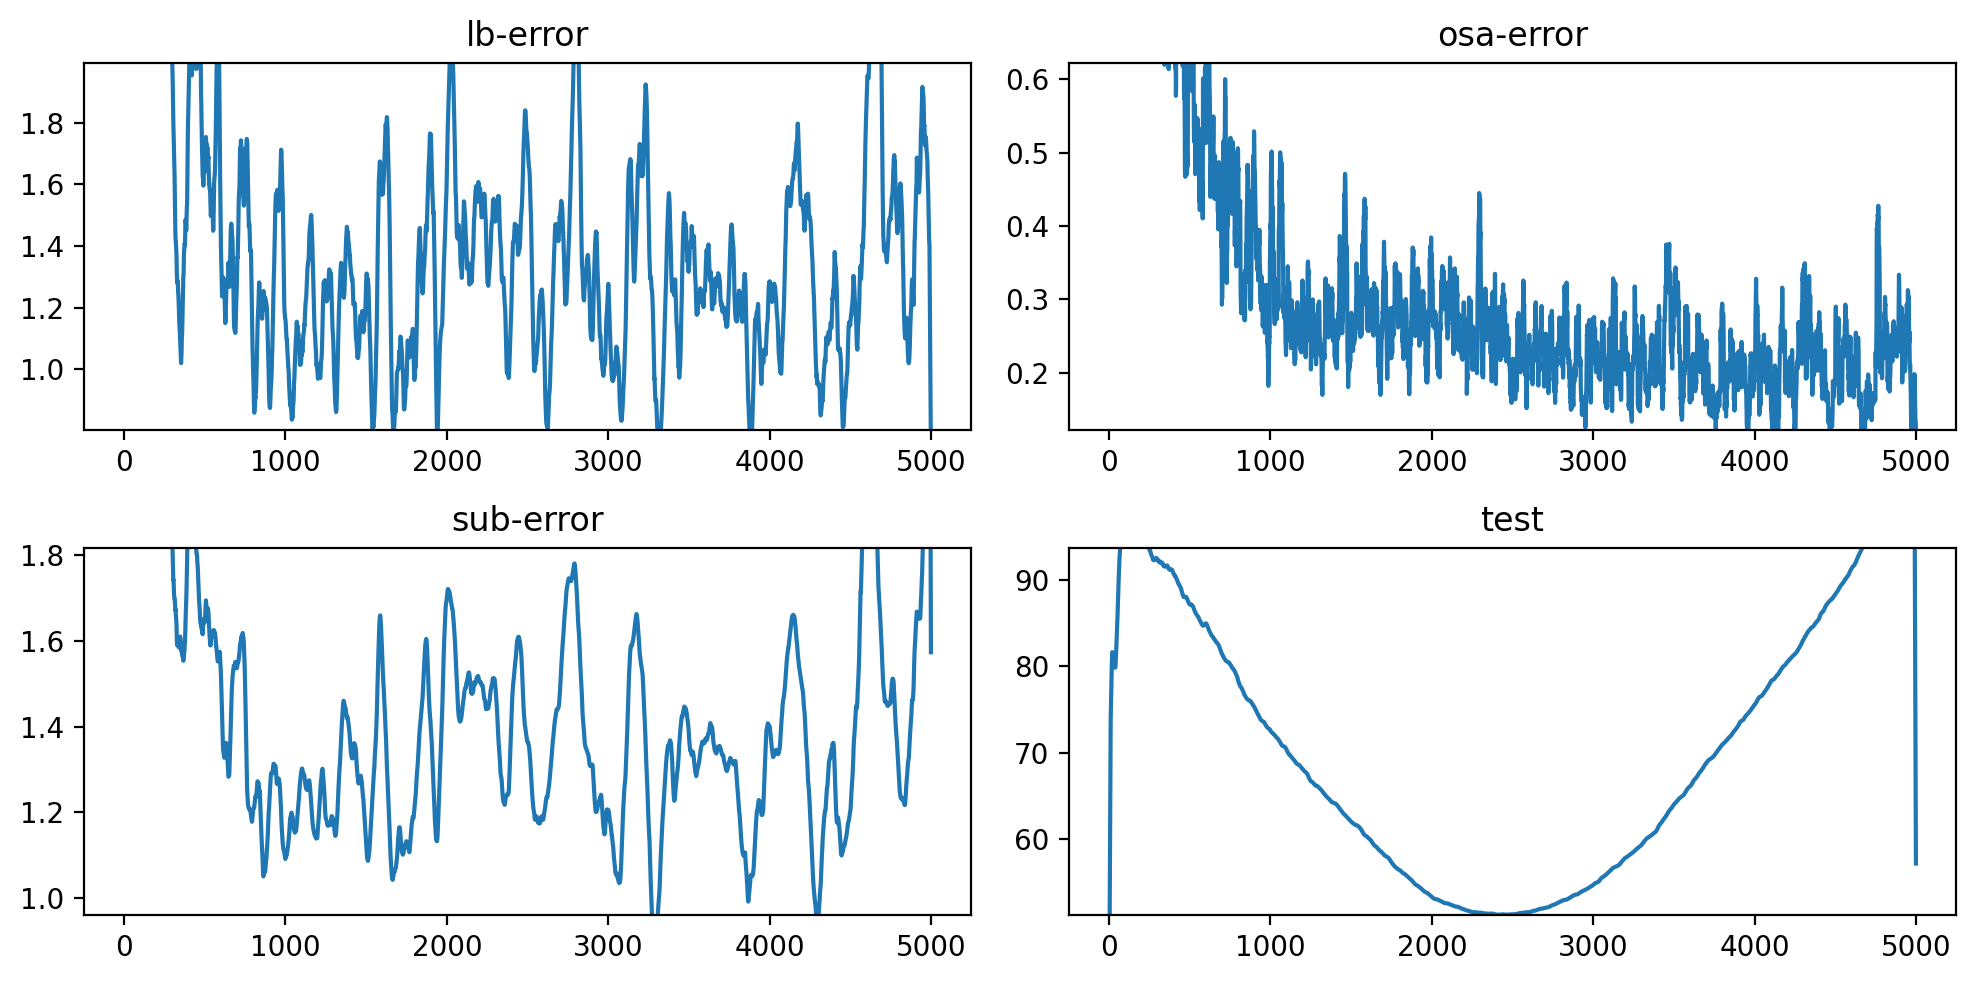

In [13]:
fig, axs = plt.subplots(2, 2, figsize=(10, 5))

for ax, keyv in zip(axs.ravel(), outputs_lofi):
    err = outputs_lofi[keyv]
    err_smooth = np.convolve(err, kernel, mode="same")
    
    vmax = np.quantile(err_smooth, 0.90)
    vmin = np.quantile(err_smooth, 0.01)
    ax.plot(err_smooth, label=keyv)
    ax.set_ylim(vmin, vmax)
    ax.set_title(keyv)
plt.tight_layout()

In [14]:
@partial(jax.pmap, in_axes=(None, 0))
@partial(jax.vmap, in_axes=(0, None))
def eval_run(dcov, inflation):
    ssm_params = base.RebayesParams(
        initial_mean=flat_params,
        initial_covariance=0.01,
        dynamics_weights=1,
        dynamics_covariance=dcov,
        emission_mean_function=partial(apply_fn_flat, model=model, recfn=recfn),
        emission_cov_function = lambda w,x: 0.05, # 0.02
        adaptive_emission_cov=False,
        dynamics_covariance_inflation_factor=inflation
    )
    
    lofi_params = lofi.LoFiParams(memory_size=mem, steady_state=False, inflation="hybrid")
    agent = lofi.RebayesLoFiDiagonal(ssm_params, lofi_params)
    bel, outputs = agent.scan(X_train, Y_train, progress_bar=False, callback=callback_part)
    
    outputs["inflation"] = inflation
    outputs["dynamics_cov"] = dcov
    
    return outputs

In [15]:
dynamics_cov_vals = jnp.sort(jnp.array([0.0, 1e-2, 1e-3, 1e-4, 1e-5]))
inflation_vals = jnp.sort(jnp.array([0.0, 0.05, 0.01, 0.001, 0.1, 0.5]))

In [16]:
%%time
outputs = eval_run(dynamics_cov_vals, inflation_vals)
outputs = jax.block_until_ready(outputs)
outputs = tree_to_cpu(outputs)

CPU times: user 20.3 s, sys: 783 ms, total: 21.1 s
Wall time: 20.5 s


In [17]:
ksize = 20
kernel = np.ones(ksize) / ksize

Text(0.5, 1.0, 'OSA—no inflation')

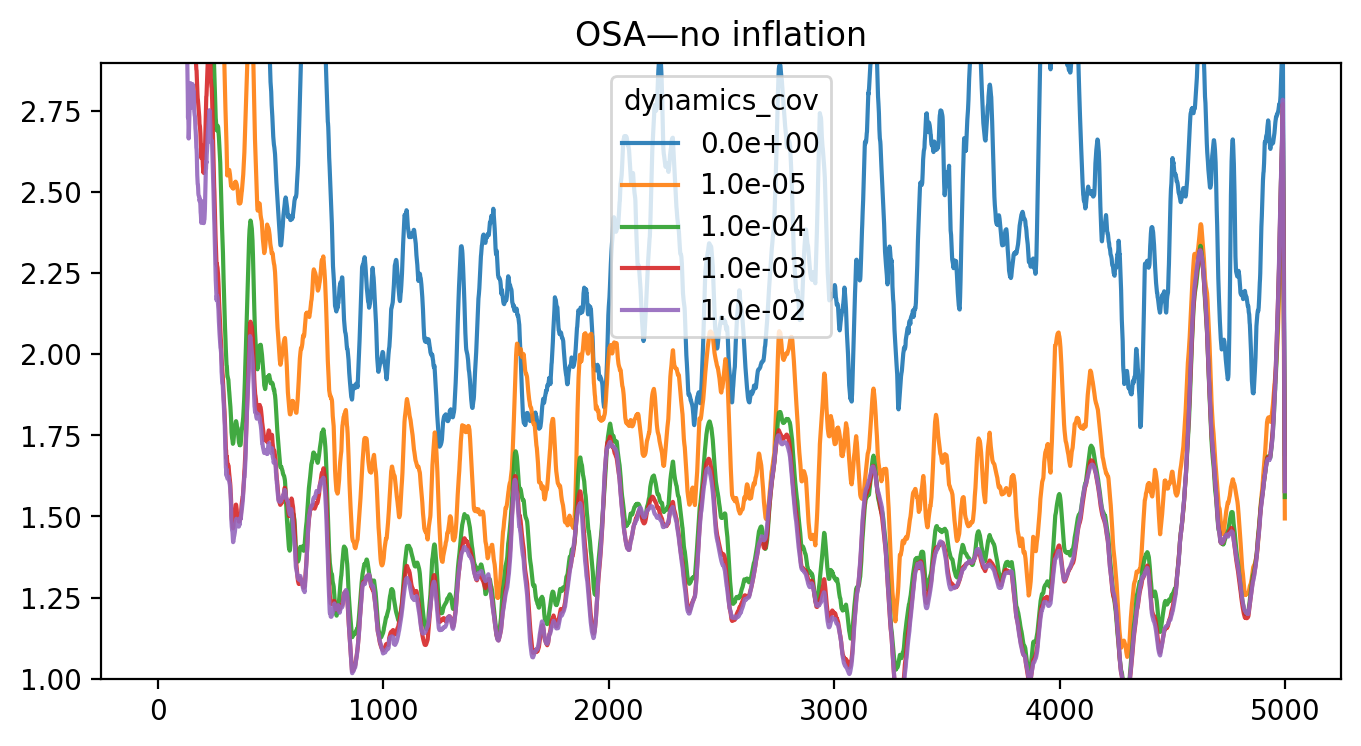

In [18]:
osa_array = outputs["sub-error"][0, ...]

fig, ax = plt.subplots(figsize=(8, 4))
for dcov, osa in zip(dynamics_cov_vals, osa_array):
    osa_smooth = np.convolve(osa, kernel, mode="same")
    plt.plot(osa_smooth, label=format(dcov, ".1e"), alpha=0.9)
    
# vmax = np.quantile(osa_smooth, 0.90)
# vmin = np.quantile(osa_smooth, 0.00)
plt.ylim(1.0, 2.9)
plt.legend(title="dynamics_cov")
plt.title("OSA—no inflation")

Text(0.5, 1.0, 'OSA—no dynamics cov')

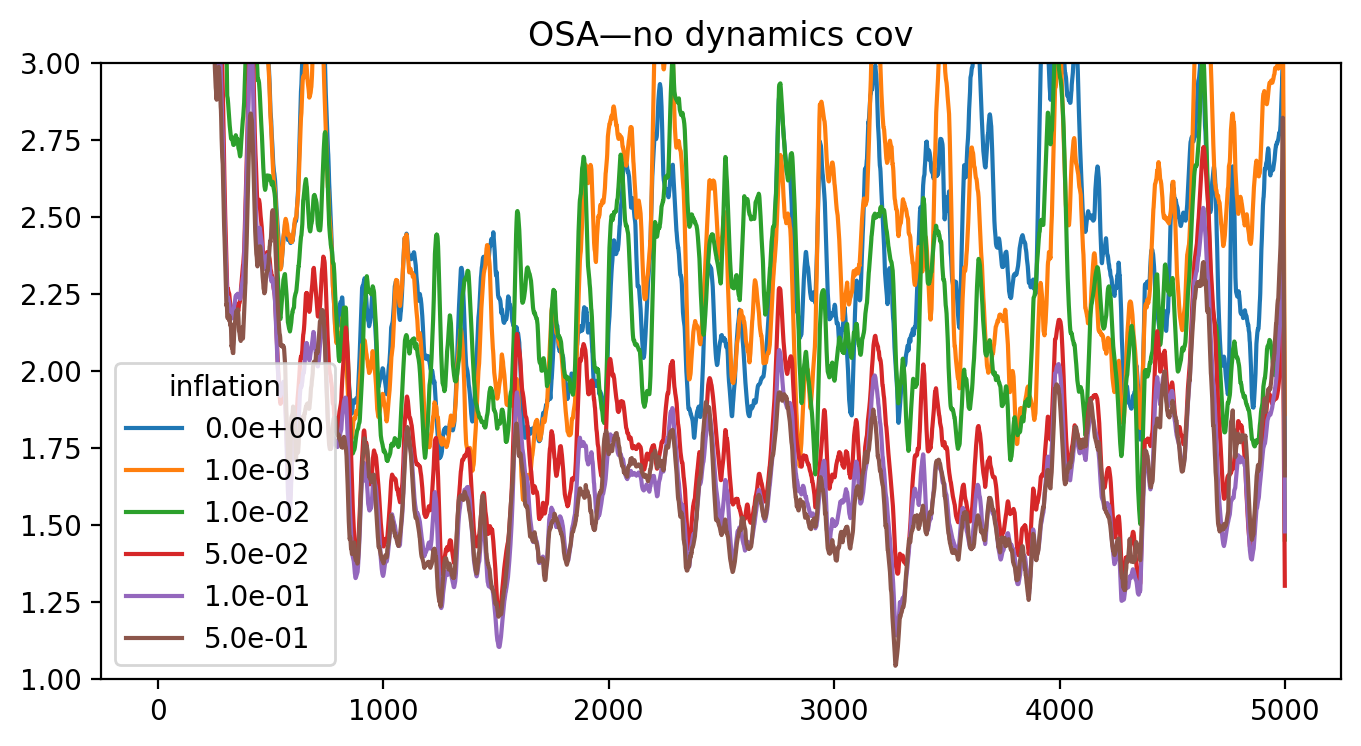

In [19]:
osa_array = outputs["sub-error"][:, 0, ...]

fig, ax = plt.subplots(figsize=(8, 4))
for dcov, osa in zip(inflation_vals, osa_array):
    osa_smooth = np.convolve(osa, kernel, mode="same")
    plt.plot(osa_smooth, label=format(dcov, ".1e"))


vmin, vmax = 1.0, 3.0
plt.ylim(vmin, vmax)
plt.legend(title="inflation")
plt.title("OSA—no dynamics cov")

Text(0.5, 1.0, 'mean o.s.a pp')

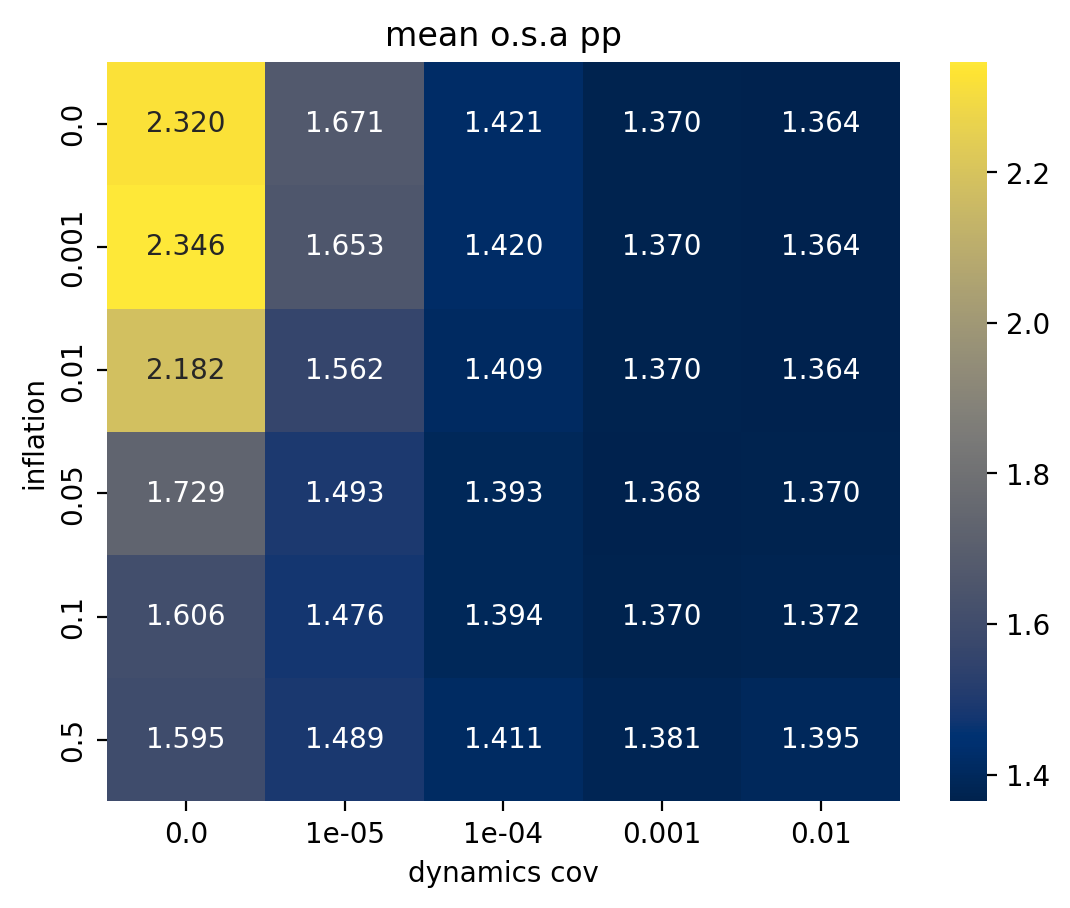

In [22]:
sns.heatmap(jnp.mean(outputs["sub-error"][..., 1000:], axis=-1),
            yticklabels=inflation_vals, xticklabels=dynamics_cov_vals,
            cmap="cividis", annot=True, fmt="0.3f")
plt.xlabel("dynamics cov")
plt.ylabel("inflation")
plt.title("mean o.s.a pp")

## Fifo Buffer

In [25]:
@partial(jax.jit, static_argnames=("apply_fn",))
def lossfn_rmse_fifo(params, counter, X, y, apply_fn):
    yhat = apply_fn(params, X).ravel()
    y = y.ravel()
    err = jnp.power(y - yhat, 2)
    loss = (err * counter).sum() / counter.sum()
    return loss


## R-SGD
### ADAM

In [26]:
lr, buffer = 5e-3, 10
agent = rsgd.FifoSGD(lossfn_rmse_fifo, 
                    apply_fn=partial(apply_fn_unflat, model=model),
                    init_params = dnn_params,
                    tx = optax.adam(learning_rate=lr),
                    buffer_size = buffer,
                    dim_features = X_train.shape[1],
                    dim_output = 1,
                    n_inner=1)


In [27]:
callback_part = partial(callback,
                        apply_fn=model.apply,
                        ymean=data["ymean"], ystd=data["ystd"],
                        X_test=X_test, y_test=y_test)

bel, outputs = agent.scan(X_train, Y_train, progress_bar=True, callback=callback_part)
bel = jax.block_until_ready(bel)
outputs_rsgd_adam = tree_to_cpu(outputs)

  0%|          | 0/5000 [00:00<?, ?it/s]

## R-SGD
### SGD

In [28]:
lr, buffer = 1e-2, 10
agent = rsgd.FifoSGD(lossfn_rmse_fifo, 
                    apply_fn=partial(apply_fn_unflat, model=model),
                    init_params = dnn_params,
                    tx = optax.sgd(learning_rate=lr),
                    buffer_size = buffer,
                    dim_features = X_train.shape[1],
                    dim_output = 1,
                    n_inner=1)


In [29]:
callback_part = partial(callback,
                        apply_fn=model.apply,
                        ymean=data["ymean"], ystd=data["ystd"],
                        X_test=X_test, y_test=y_test)

bel, outputs = agent.scan(X_train, Y_train, progress_bar=True, callback=callback_part)
bel = jax.block_until_ready(bel)
outputs_rsgd = tree_to_cpu(outputs)

  0%|          | 0/5000 [00:00<?, ?it/s]

## Plot comparisson

In [30]:
ksize = 10
kernel = np.ones(ksize) / ksize

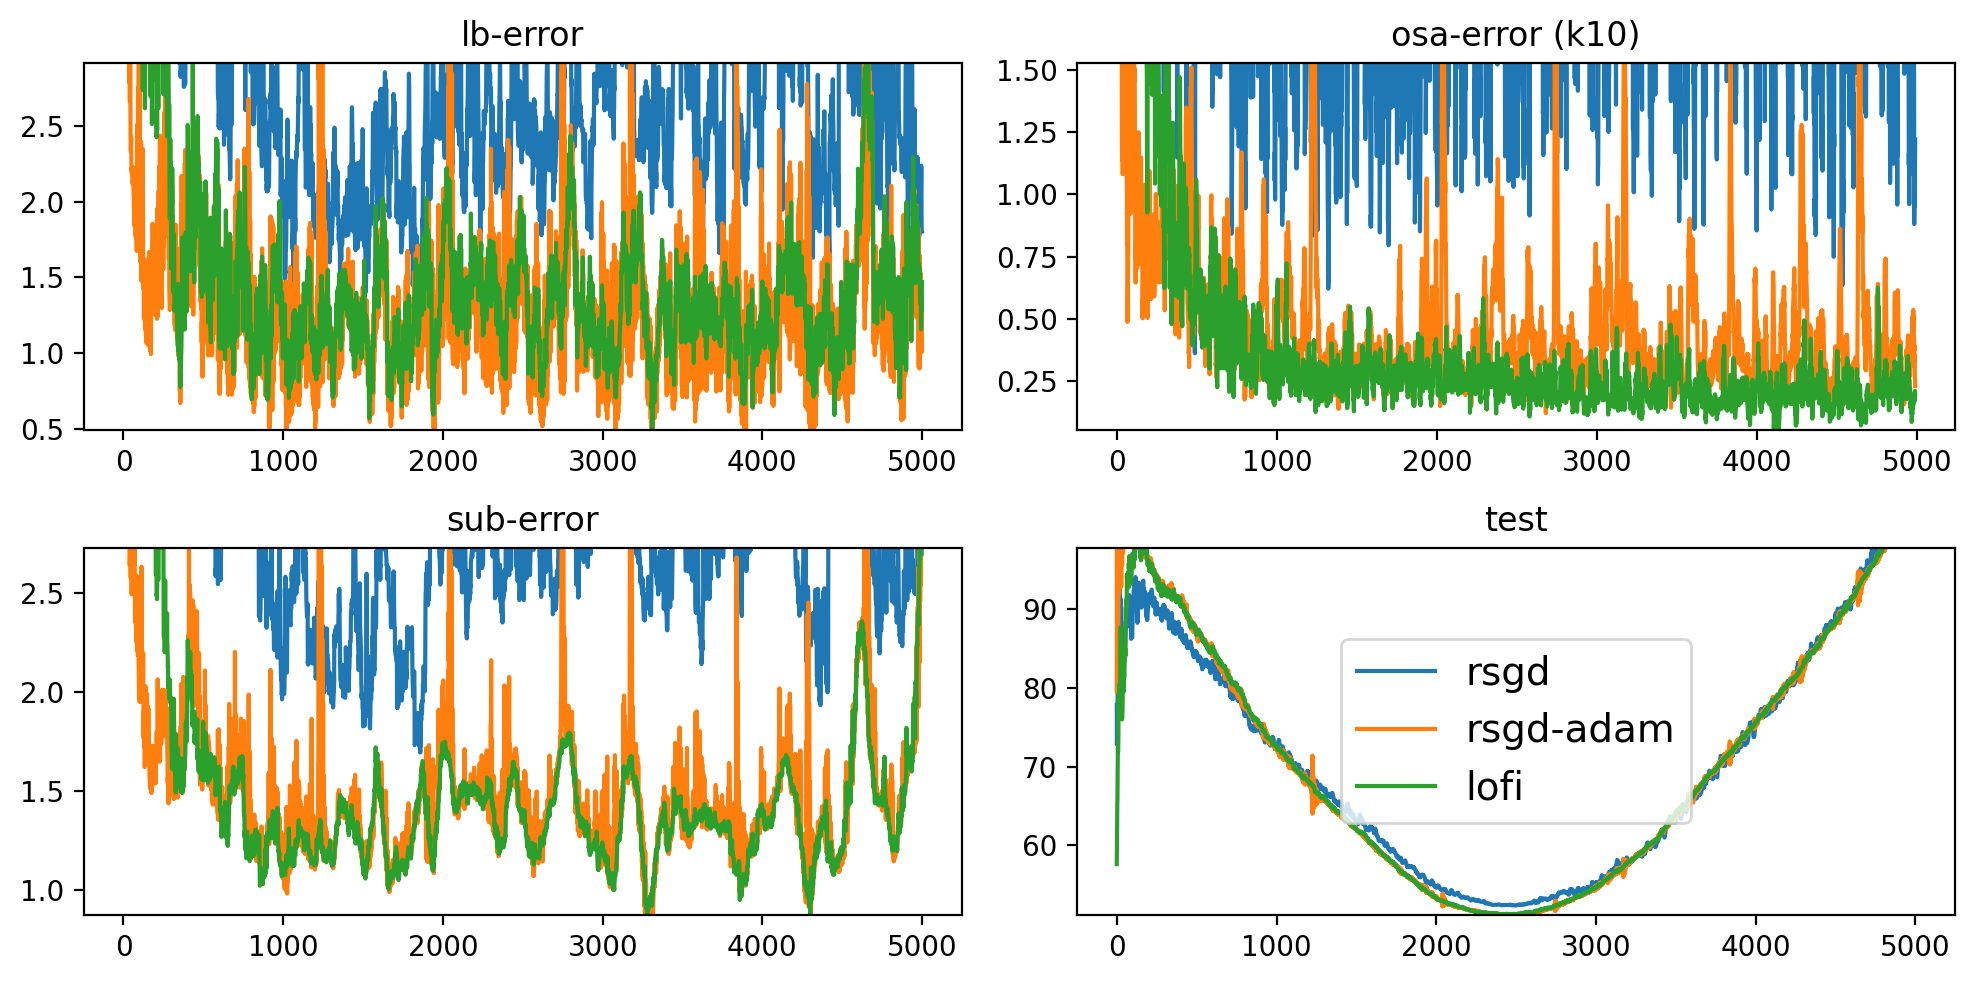

In [31]:
fig, axs = plt.subplots(2, 2, figsize=(10, 5))

for ax, keyv in zip(axs.ravel(), outputs_rsgd):
    err_rsgd = outputs_rsgd[keyv]
    err_rsgd_adam = outputs_rsgd_adam[keyv]
    err_lofi = outputs_lofi[keyv]
    
    if keyv == "osa-error":
        err_rsgd = np.convolve(err_rsgd, kernel, mode="valid")
        err_rsgd_adam = np.convolve(err_rsgd_adam, kernel, mode="valid")
        err_lofi = np.convolve(err_lofi, kernel, mode="valid")
        keyv = f"osa-error (k{ksize})"

    vmax = np.quantile(err_lofi, 0.95)
    vmin = np.quantile(err_lofi, 0.00)
    ax.plot(err_rsgd, label="rsgd")
    ax.plot(err_rsgd_adam, label="rsgd-adam")
    ax.plot(err_lofi, label="lofi")
    
    ax.set_ylim(vmin, vmax)
    ax.set_title(keyv)
axs[1, 1].legend(loc="center", fontsize=14)
plt.tight_layout()